Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# %load /home/isajosep/.ipython/standard_imports.py
import logging
logging.basicConfig(level=logging.INFO)

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import numpy as np

import isajosep_util
import os

#!echo 'import os'  >> /home/isajosep/.ipython/standard_imports.py
import matplotlib.pyplot as plt
import seaborn as sns
import isajosep_util.data_frame_plotter
sns.set_palette([v.value for v in isajosep_util.data_frame_plotter.AgilentColors])
import tqdm


In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

First reload the data we generated in `1_notmnist.ipynb`.

In [3]:
import os
data_root = os.path.join(os.path.expanduser('~'), 'Data/Udacity_Tensorflow')
os.chdir(data_root)

In [4]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [5]:
image_size = 28
num_labels = 10


def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
    labels = (np.arange(num_labels) == labels[:, None]).astype(np.float32)
    return dataset, labels


train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [6]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
            / predictions.shape[0])

# Problem 1


Introduce and tune $L_2$ regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [7]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():
    # Input data
    # For the training data, we use a placeholder that will be fed at run time with a training minibatch.
    # train data: rows × columns; placeholder so can do SGD
    
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(
        batch_size, num_labels))  # train labels: rows × 1

    tf_valid_dataset = tf.constant(valid_dataset)  # validation data
    tf_test_dataset = tf.constant(test_dataset)

    # Variables. (Parameters); initialize.
    # not reducing dimensionality, so same number of rows as columns; initialize as normal
    weights_layer_one = tf.Variable(tf.truncated_normal(
        [image_size * image_size, image_size * image_size]))

    # one bias per feature; initialize at zero
    biases_layer_one = tf.Variable(tf.zeros([image_size * image_size]))

    weights_layer_three = tf.Variable(
        tf.truncated_normal([image_size * image_size, num_labels]))
    biases_layer_three = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    # Network architecture: 1024 RELUs
    layer_one_output_tensor = tf.matmul(
        tf_train_dataset, weights_layer_one) + biases_layer_one
    layer_two_output_tensor = tf.nn.relu(layer_one_output_tensor)
    logits = tf.matmul(layer_two_output_tensor,
                       weights_layer_three) + biases_layer_three

    ########### new this time -- regularization (add to loss, not explicit network structure)
    beta_1 = tf.constant([0.001])
    beta_2 = tf.constant([0.001])
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + tf.multiply(beta_1,
                                                                                                                        tf.reduce_mean(tf.nn.l2_loss(weights_layer_one))) + tf.multiply(beta_2, tf.reduce_mean(tf.nn.l2_loss(weights_layer_three)))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
        tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, weights_layer_one) + biases_layer_one), weights_layer_three) + biases_layer_three)
    test_prediction = tf.nn.softmax(
        tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights_layer_one) + biases_layer_one), weights_layer_three) + biases_layer_three)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



Initialized


Minibatch loss at step 0: 544.434692
Minibatch accuracy: 7.0%
Validation accuracy: 27.0%
Minibatch loss at step 500: 150.467453
Minibatch accuracy: 78.9%
Validation accuracy: 79.8%
Minibatch loss at step 1000: 87.873268
Minibatch accuracy: 82.0%
Validation accuracy: 81.8%
Minibatch loss at step 1500: 52.829380
Minibatch accuracy: 80.5%
Validation accuracy: 82.9%
Minibatch loss at step 2000: 31.668684
Minibatch accuracy: 84.4%
Validation accuracy: 84.7%
Minibatch loss at step 2500: 19.738596
Minibatch accuracy: 82.8%
Validation accuracy: 85.9%
Minibatch loss at step 3000: 11.887938
Minibatch accuracy: 87.5%
Validation accuracy: 87.1%

Test accuracy: 93.2%


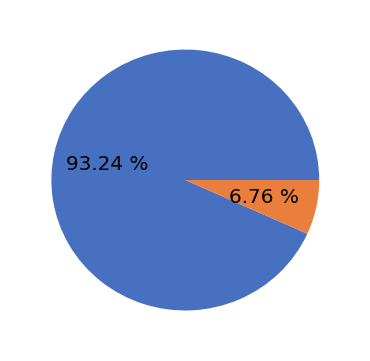

In [8]:
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in tqdm.tqdm_notebook(range(num_steps)):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset: batch_data,
                     tf_train_labels: batch_labels}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" %
                  accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(
        test_prediction.eval(), test_labels))     
    isajosep_util.plot_pie_percent(accuracy(         test_prediction.eval(), test_labels))    
    

Good when loss is about half of the total error produced by the function ($600$ vs $250$)

Wow, even better test accuracy.... 

# Problem 2

---
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [35]:
max_num_batches = (train_labels.shape[0] - batch_size) 
print("max number of batches: {:,}".format(max_num_batches))

max number of batches: 199,872


Initialized


Minibatch loss at step 0: 540.464722
Minibatch accuracy: 8.6%
Validation accuracy: 34.1%
Minibatch loss at step 500: 145.988586
Minibatch accuracy: 100.0%
Validation accuracy: 61.0%
Minibatch loss at step 1000: 88.535477
Minibatch accuracy: 100.0%
Validation accuracy: 61.1%
Minibatch loss at step 1500: 53.692772
Minibatch accuracy: 100.0%
Validation accuracy: 61.1%
Minibatch loss at step 2000: 32.562252
Minibatch accuracy: 100.0%
Validation accuracy: 61.3%
Minibatch loss at step 2500: 19.747561
Minibatch accuracy: 100.0%
Validation accuracy: 61.6%
Minibatch loss at step 3000: 11.976156
Minibatch accuracy: 100.0%
Validation accuracy: 62.0%

Test accuracy: 68.2%


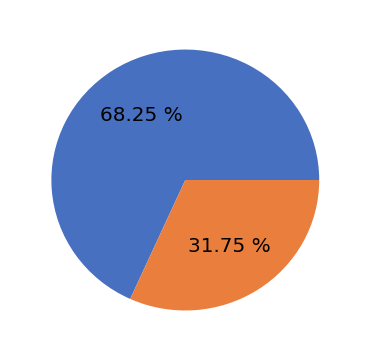

In [9]:
num_steps = 3001
batch_size = 128
num_batches = 1

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in tqdm.tqdm_notebook(range(num_steps)):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        # changed -- now only three batches
        offset = (step * batch_size) % num_batches
        
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        # tf_train_dataset is a tf.placeholder-created Tensor, whereas train_dataset is the actual np.array of training data. 
        # thus, batch_data and batch_labels are subsets of this np.array. 
        feed_dict = {tf_train_dataset: batch_data,
                     tf_train_labels: batch_labels}


        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" %
                  accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(
        test_prediction.eval(), test_labels))     
    isajosep_util.plot_pie_percent(accuracy(test_prediction.eval(), test_labels))

Hm, interesting. It's still able to reduce its loss by reducing the norm of the weight matrices $\mathbf{W}$, but it's not able to make a significant impact on its validation accuracy in that manner, as it's only using one batch of size 128. 

# Problem 3

---

---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

## Graph

Hm, do I do this in the `tf.Session` or in the `tf.Graph`? `tf.Graph .`

In [18]:
batch_size = 128
dropout_keep_prob = 0.3

dropout_graph = tf.Graph()
with dropout_graph.as_default():
    # Input data
    # For the training data, we use a placeholder that will be fed at run time with a training minibatch.
    # train data: rows × columns; placeholder so can do SGD
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(
        batch_size, num_labels))  # train labels: rows × 1

    tf_valid_dataset = tf.constant(valid_dataset)  # validation data
    tf_test_dataset = tf.constant(test_dataset)

    # Variables. (Parameters); initialize.
    # not reducing dimensionality, so same number of rows as columns; initialize as normal
    weights_layer_one = tf.Variable(tf.truncated_normal(
        [image_size * image_size, image_size * image_size]))
    # one bias per feature; initialize at zero
    biases_layer_one = tf.Variable(tf.zeros([image_size * image_size]))

    weights_layer_three = tf.Variable(
        tf.truncated_normal([image_size * image_size, num_labels]))
    biases_layer_three = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    # Network architecture: 1024 RELUs
    layer_one_output_tensor = tf.matmul(
        tf_train_dataset, weights_layer_one) + biases_layer_one
    
    # additional dropout layer
    layer_two_output_tensor = tf.nn.relu(tf.nn.dropout(layer_one_output_tensor, keep_prob=dropout_keep_prob))

    logits = tf.matmul(layer_two_output_tensor,
                       weights_layer_three) + biases_layer_three

    # new this time -- regularization
    beta_1 = tf.constant([0.001])
    beta_2 = tf.constant([0.001])
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + tf.multiply(beta_1,
                                                                                                                        tf.reduce_mean(tf.nn.l2_loss(weights_layer_one))) + tf.multiply(beta_2, tf.reduce_mean(tf.nn.l2_loss(weights_layer_three)))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
        tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, weights_layer_one) + biases_layer_one), weights_layer_three) + biases_layer_three)
    test_prediction = tf.nn.softmax(
        tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights_layer_one) + biases_layer_one), weights_layer_three) + biases_layer_three)

## Session

Initialized


Minibatch loss at step 0: 811.780396
Minibatch accuracy: 13.3%
Validation accuracy: 39.2%
Minibatch loss at step 500: 171.161636
Minibatch accuracy: 62.5%
Validation accuracy: 78.3%
Minibatch loss at step 1000: 92.902496
Minibatch accuracy: 56.2%
Validation accuracy: 77.9%
Minibatch loss at step 1500: 55.107182
Minibatch accuracy: 69.5%
Validation accuracy: 79.4%
Minibatch loss at step 2000: 32.853439
Minibatch accuracy: 77.3%
Validation accuracy: 81.3%
Minibatch loss at step 2500: 20.508121
Minibatch accuracy: 71.9%
Validation accuracy: 83.1%
Minibatch loss at step 3000: 12.182432
Minibatch accuracy: 79.7%
Validation accuracy: 83.5%

Test accuracy: 90.4%


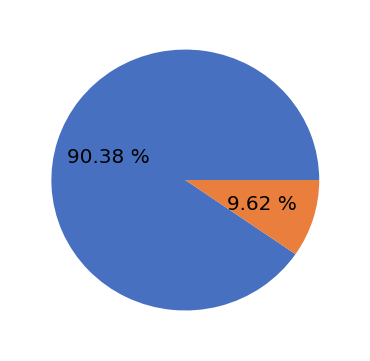

In [19]:
num_steps = 3001
batch_size = 128
num_batches = max_num_batches

with tf.Session(graph=dropout_graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in tqdm.tqdm_notebook(range(num_steps)):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % num_batches
        
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        # tf_train_dataset is a tf.placeholder-created Tensor, whereas train_dataset is the actual np.array of training data. 
        # thus, batch_data and batch_labels are subsets of this np.array. 
        feed_dict = {tf_train_dataset: batch_data,
                     tf_train_labels: batch_labels}


        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" %
                  accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(
        test_prediction.eval(), test_labels))     
    isajosep_util.plot_pie_percent(accuracy(         test_prediction.eval(), test_labels))

Hm, yes,rescued 2% using 0.7 dropout, 5% using 0.5 dropout, 8% using 0.3 dropout, 2% using 0.1 dropout.  

# Problem 4
---

---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [45]:
batch_size = 128
dropout_keep_prob = 0.5
learning_rate_init = 0.001
decay_steps = 1000
decay_rate = 0.5
beta_1_value = 1e-3
beta_2_value = 1e-3
beta_3_value = 1e-3

best_possible_graph = tf.Graph()
with best_possible_graph.as_default():
    # Input data
    # For the training data, we use a placeholder that will be fed at run time with a training minibatch.
    # train data: rows × columns; placeholder so can do SGD
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(
        batch_size, num_labels))  # train labels: rows × 1

    tf_valid_dataset = tf.constant(valid_dataset)  # validation data
    tf_test_dataset = tf.constant(test_dataset)

    ############################## Variables. (Parameters); initialize.
    # not reducing dimensionality, so same number of rows as columns; initialize as normal
    
    # W₁: (number_of_pixels_per_image × number_of_pixels_per_image)
    # b₁: (number_of_pixels_per_image × 1)    
    weights_layer_one = tf.Variable(tf.truncated_normal(
        [image_size * image_size, image_size * image_size]))
    # one bias per feature; initialize at zero
    biases_layer_one = tf.Variable(tf.zeros([image_size * image_size]))
    
    # W₂: (number_of_pixels_per_image × number_of_pixels_per_image)
    # b₂: (number_of_pixels_per_image × 1)
    weights_layer_three = tf.Variable(
        tf.truncated_normal([image_size * image_size, image_size * image_size]))
    biases_layer_three = tf.Variable(tf.zeros([image_size * image_size]))

    # W₃: (number_of_pixels_per_image × num_labels(=10))
    # b₃: (num_labels(=10) × 1)
    weights_layer_four = tf.Variable(
        tf.truncated_normal([image_size * image_size, num_labels]))
    biases_layer_four = tf.Variable(tf.zeros([num_labels]))

    ############################## Training computation (layer specification using variables above and other methods).

    #  layer 1 : (n_train × number_of_pixels_per_image)  → (n_train × number_of_pixels_per_image)
    layer_one_output_tensor = tf.matmul(
        tf_train_dataset, weights_layer_one) + biases_layer_one 

    # additional dropout/ RELU layer
    # layer 2 : (n_train × number_of_pixels_per_image)  → (n_train × number_of_pixels_per_image)
    layer_two_output_tensor = tf.nn.relu(tf.nn.dropout(
        layer_one_output_tensor, keep_prob=dropout_keep_prob)) 

    #  additional regular layer
    # layer 3 : (n_train × number_of_pixels_per_image)  → (n_train × number_of_pixels_per_image)
    layer_three_output_tensor = tf.matmul(layer_two_output_tensor, weights_layer_three) + biases_layer_three  

    # output:  (n_train × number_of_pixels_per_image)  → (n_train × num_labels(=10))
    logits = tf.matmul(layer_three_output_tensor,
                       weights_layer_four) + biases_layer_four
    
    ############################## Objective function
    # Regularization of *weights*: objective + β₁‖W₁‖₂ + β₂‖W₂‖₂ + β₃‖W₃‖₂
    beta_1 = tf.constant([beta_1_value])
    beta_2 = tf.constant([beta_2_value])
    beta_3 = tf.constant([beta_3_value])
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + tf.multiply(beta_1,
                                                                                                                        tf.reduce_mean(tf.nn.l2_loss(weights_layer_one))) + tf.multiply(beta_2, tf.reduce_mean(tf.nn.l2_loss(weights_layer_three))) + tf.multiply(beta_3, tf.reduce_mean(tf.nn.l2_loss(weights_layer_four)))

    ############################## Optimizer
    global_step = tf.Variable(0)  # initialize at zero
    
    learning_rate = tf.train.exponential_decay(learning_rate=learning_rate_init, global_step=global_step, decay_steps=decay_steps,
                                               decay_rate=decay_rate, staircase=False)  # a scalar Tensor of the same type as `learning_rate` (in this case, float64)
    # Exponential decay: decayed_learning_rate = learning_rate *
    #                         decay_rate ^ (global_step / decay_steps)
    # if staircase=True, decay steps is how many steps before decay kicks in. Higher value ⇒ lower rate of decay; otherwise, this is done at every step

    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(
        loss=loss, global_step=global_step)  # will global_step be updated?

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul((tf.matmul(tf.nn.relu((tf.matmul(tf_valid_dataset, weights_layer_one) + biases_layer_one)), weights_layer_three) + biases_layer_three), weights_layer_four) + biases_layer_four)
    test_prediction = tf.nn.softmax(tf.matmul((tf.matmul(tf.nn.relu((tf.matmul(tf_test_dataset, weights_layer_one) + biases_layer_one)), weights_layer_three) + biases_layer_three), weights_layer_four) + biases_layer_four)

Initialized


Minibatch loss at step 0: 11,138.2; Minibatch accuracy: 10.2%; Validation accuracy: 13.9%
Minibatch loss at step 500: 1,527.3; Minibatch accuracy: 69.5%; Validation accuracy: 82.0%
Minibatch loss at step 1000: 1,028.6; Minibatch accuracy: 75.0%; Validation accuracy: 82.8%
Minibatch loss at step 1500: 1,038.0; Minibatch accuracy: 70.3%; Validation accuracy: 83.5%
Minibatch loss at step 2000: 845.6; Minibatch accuracy: 78.9%; Validation accuracy: 83.6%
Minibatch loss at step 2500: 956.4; Minibatch accuracy: 72.7%; Validation accuracy: 83.7%

Test accuracy: 90.3%


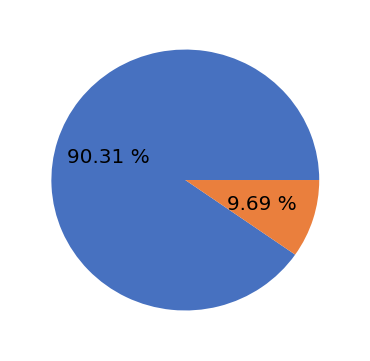

In [46]:
num_steps = 3000
num_batches = (train_labels.shape[0] - batch_size)  # Max number of possible batches: all possible starting positions in the training set

with tf.Session(graph=best_possible_graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in tqdm.tqdm_notebook(range(num_steps)):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size)  % num_batches 
        
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        # tf_train_dataset is a tf.placeholder-created Tensor, whereas train_dataset is the actual np.array of training data. 
        # thus, batch_data and batch_labels are subsets of this np.array. 
        feed_dict = {tf_train_dataset: batch_data,
                     tf_train_labels: batch_labels}


        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if (step % 500 == 0):
            print("Minibatch loss at step {}: {:,.1f}".format(step, l[0]), end='; ')
            print("Minibatch accuracy: %.1f%%" %
                  accuracy(predictions, batch_labels), end='; ' )
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(
        test_prediction.eval(), test_labels))     
    isajosep_util.plot_pie_percent(accuracy(test_prediction.eval(), test_labels))

Hm, larger batch size doesn't necessarily matter for accuracy after a certain point (has diminishing returns). However, it takes much longer. 